In [ ]:
##########################################################
# パッケージの読み込みとエイリアスの設定
##########################################################
using Revise, LinearAlgebra, LaTeXStrings, Plots, CSV, DataFrames, JLD2, Random, Statistics, Distributions
using TensorCrossInterpolation
import TensorCrossInterpolation as TCI
using Tensor_FixedSeedMC
import Tensor_FixedSeedMC as TCIMC


In [2]:
##########################################################
# ユーティリティ関数の定義
##########################################################
# Chebyshev節点を計算する関数
function calc_cheby_abscissas(a::Float64, b::Float64, n::Int)
    @assert b > a "calc_cheby_abscissas: need a < b"
    @assert n >= 1 "calc_cheby_abscissas: n < 1"
    bma = 0.5*(b - a)
    bpa = 0.5*(b + a)
    # k = 0,...,n-1 の各点での値を計算し、反転して返す
    return [cos(pi*(k+0.5)/n)*bma + bpa for k in reverse(0:(n-1))]
end

calc_cheby_abscissas (generic function with 1 method)

In [3]:


# アジアン・バリアオプションのモンテカルロシミュレーション（インデックス渡し版）
function asian_barrier_option_tci(j, T, K, B, S0s, sigmas, mu, r, d_normals, N_STEPS, N_PATHS)
    tmp1 = mu * T / N_STEPS
    tmp2 = exp(-r * T)
    tmp3 = sqrt(T / N_STEPS)
    discounted_payoffs = zeros(Float64, N_PATHS)
    S0 = S0s[j[1]]
    sigma = sigmas[j[2]]
    for i in 1:N_PATHS
        s_curr = S0
        running_avg = 0.0
        for n in 1:N_STEPS
            s_curr += tmp1 * s_curr + sigma * s_curr * tmp3 * d_normals[i + (n-1)*N_PATHS]
            running_avg += (s_curr - running_avg) / n
            if running_avg <= B
                break
            end
        end
        discounted_payoffs[i] = tmp2 * max(running_avg - K, 0)
    end
    return mean(discounted_payoffs)
end


# TCIワンショット補間関数
function tci_oneshot(func, d, localdims, firstpivot, tol)
    BLAS.set_num_threads(4)
    for _ in 1:100
        p = TCI.optfirstpivot(func, localdims, firstpivot)
        if abs(func(p)) > abs(func(firstpivot))
            firstpivot = p
        end
    end
    qtt, ranks, errors = TCI.crossinterpolate2(Float64, func, localdims, [firstpivot],
                                                  tolerance=tol, maxiter=6, verbosity=1,
                                                  loginterval=1, pivotsearch=:rook)
    return qtt, errors
end

tci_oneshot (generic function with 1 method)

In [4]:


##########################################################
# パラメータの設定とグリッド生成
##########################################################
d = 2
N_STEPS = 365
N_PATHS = 100000       # サンプル数（テスト用なので少なめ）
T = 1.0
K = 110.0
B = 100.0
mu = 0.1
r = 0.05

Random.seed!(1234)
d_normals = randn(Float64, N_STEPS * N_PATHS)

num_nodes = 50
n = num_nodes
S0_values = calc_cheby_abscissas(90.0, 120.0, num_nodes)
implied_vol_values = calc_cheby_abscissas(0.15, 0.25, num_nodes)

# インデックスを渡す設計のため、例として j = [30, 30] を利用
j = [30, 30]
println("Option Price (MC, single point): ", asian_barrier_option_tci(j, T, K, B, S0_values, implied_vol_values, mu, r, d_normals, N_STEPS, N_PATHS))



Option Price (MC, single point): 7.930086767962758


In [5]:
##########################################################
# TCI のキャッシュ関数設定とワンショット補間の実行
##########################################################
# 関数 abo は asian_barrier_option_tci のラッパー（引数はインデックス）
abo(j) = asian_barrier_option_tci(j, T, K, B, S0_values, implied_vol_values, mu, r, d_normals, N_STEPS, N_PATHS)
localdims_v = fill(num_nodes, d)
firstpivot_v = rand(1:num_nodes, d)
phi = TCI.CachedFunction{Float64}(abo, localdims_v)
tol = 1e-3

#tci_time = @elapsed begin
#    tt_sin, errors_sin = tci_oneshot(phi, d, localdims_v, firstpivot_v, tol)
#end

##########################################################

0.001

In [6]:
JLD2.@load "tt_sin_$tol.jld2" tt_sin
tt_sin = tt_sin

(::TensorCrossInterpolation.TensorCI2{Float64}) (generic function with 1 method)

## chebyshev補間

In [7]:
# テンソル列車を保持する構造体
struct MyTensorTrain{T}
    M::Vector{Array{T,3}}
end

# 各コアに行列 A を掛ける関数（物理次元＝第2モードに対して）
function compute_chebyshev_coeff(tt::MyTensorTrain{T}, A::Vector{<:AbstractMatrix{T}}) where T
    new_cores = Vector{Array{T,3}}(undef, length(tt.M))
    for i in 1:length(tt.M)
        core = tt.M[i]
        r1, n, r2 = size(core)
        p, nA = size(A[i])
        @assert n == nA "Matrix A の列数とコアの第2次元のサイズが一致していません。"
        new_core = zeros(T, r1, p, r2)
        # 各左側インデックスと右側インデックスに対して、第2モードのスライスに行列積を適用
        for i1 in 1:r1
            for i3 in 1:r2
                new_core[i1, :, i3] = A[i] * core[i1, :, i3]
            end
        end
        new_cores[i] = new_core .* (2.0 / n)
    end
    return MyTensorTrain{T}(new_cores)
end

function dct_matrix(N::Int)
    @assert N >= 1 "dct_matrix: N must be >= 1"
    if N == 1
        return [1.0]
    end
    M = zeros(Float64, N, N)
    for k in 0:(N-1)
        for j in 0:(N-1)
            M[k+1, j+1] = cos(pi * k * (j + 0.5) / N)
        end
    end
    # calc_cheby_abscissas が返す節点の順序に合わせるため、列を反転する
    return reverse(M, dims=2)
    #return M
end


function chebyshev_basis(a::Float64, b::Float64, x::Float64, N::Int)
    # x の範囲チェック
    if x < a || x > b
        error("x is out of bounds")
    end
    # 変数変換
    y = (2*x - (a + b)) / (b - a)
    y = clamp(y, -1.0, 1.0)  # ここで [-1, 1] にクリップする
    theta = acos(y)
    k = 0:(N-1)
    T_vals = cos.(theta .* k)
    scale = ones(Float64, N)
    scale[1] = 0.5
    return scale .* T_vals
end


# TCI用テンソル列車（TensorTrain）のキャッシュ計算関数
function compute_left_cache(tt::MyTensorTrain{T}, weights::Vector{Vector{Float64}}, c::Int) where T
    L = ones(T, 1, 1)
    for s in 1:(c-1)
        r, n, r_next = size(tt.M[s])
        LM = reshape(L * reshape(tt.M[s], r, n*r_next), n, r_next)
        L = reshape(weights[s], 1, n) * LM
    end
    return L
end

function compute_right_cache(tt::MyTensorTrain{T}, weights::Vector{Vector{Float64}}, c::Int) where T
    N = length(tt.M)
    R = ones(T, 1, 1)
    for s in N:-1:(c+1)
        r, n, r_next = size(tt.M[s])
        MR = reshape(reshape(tt.M[s], r*n, r_next) * R, r, n)
        R = MR * reshape(weights[s], n, 1)
    end
    return R
end

function update_center(tt::MyTensorTrain{T}, L::Array{T,2}, R::Array{T,2}, new_weight::Vector{Float64}, c::Int) where T
    M_c = tt.M[c]
    r_prev, n, r_next = size(M_c)
    LM = reshape(L * reshape(M_c, r_prev, n*r_next), n, r_next)
    center = reshape(new_weight, 1, n) * LM
    return (center * R)[1,1]
end


tt_sin_ = MyTensorTrain{Float64}(tt_sin.sitetensors)


MyTensorTrain{Float64}([[0.0 0.0 … 0.9950410756121061 1.0;;; -0.0 -0.0 … 0.0045856230309581966 0.0;;; -0.0 -0.0 … 0.013486124415174622 0.0], [15.6722298921351 15.673710612741083 … 16.932422709170137 16.935609878986742; 4.692182574278449 4.696970896662494 … 6.882199634479445 6.886110106939647; 0.009459974670440349 0.009782457466264357 … 0.18504069096700346 0.1853824496679529;;;]])

In [8]:
C_coeff_tensor = compute_chebyshev_coeff(tt_sin_, fill(dct_matrix(n), 2))
C_coeff_tensor

MyTensorTrain{Float64}([[0.5528495762678554 0.4721445552655661 … -0.00014847734819551706 0.00013259123146544609;;; 0.6087753497804891 0.14410430700753507 … 0.0006131336723306714 -0.0006510063639852524;;; 0.3925219636330966 0.1880900296232217 … -0.01213235347216228 0.019389800522929553], [32.49496409986529 0.6361847439052865 … -6.266766201276019e-6 2.1665307602816974e-6; 11.624081047077514 1.0987573091699638 … 3.3376032114273555e-5 -2.6072258133792164e-5; 0.16100008912240968 0.08751209626063794 … 3.190705935926917e-6 -9.266776743408636e-5;;;]])

In [9]:
# Chebyshev basis derivative with respect to x:
# d/dx cos(kθ) = k * (2/(b-a))/√(1-y²) * sin(kθ)
function chebyshev_basis_derivative(a::Float64, b::Float64, x::Float64, N::Int)
    if x < a || x > b error("x is out of bounds") end
    y = (2*x - (a+b))/(b-a)
    theta = acos(y)
    c = 2/(b-a)
    return [ (k == 0 ? 0.0 : k * c/sqrt(1 - y^2) * sin(k * theta))
             for k in 0:(N-1) ]
end


chebyshev_basis_derivative (generic function with 1 method)

In [10]:
# 等間隔グリッドの作成
num_nodes = 10
S0_values = collect(range(90.0, stop=120.0, length=num_nodes))
implied_vol_values = collect(range(0.15, stop=0.25, length=num_nodes))

# TCIによる評価結果の行列作成
price_matrix_tci = zeros(length(S0_values), length(implied_vol_values))
for (i_idx, s0_val) in enumerate(S0_values)
    for (j_idx, vol_val) in enumerate(implied_vol_values)
        # 各パラメータについてChebyshev基底を評価
        weights = [chebyshev_basis(90.0, 120.0, s0_val, n),
                   chebyshev_basis(0.15, 0.25, vol_val, n)]
        c = 1
        left_cache = compute_left_cache(C_coeff_tensor, weights, c)
        right_cache = compute_right_cache(C_coeff_tensor, weights, c)
        result_original = update_center(C_coeff_tensor, left_cache, right_cache, weights[c], c)
        price_matrix_tci[i_idx, j_idx] = result_original
    end
end

println("TCIの評価結果 (等間隔グリッド):")
display(price_matrix_tci)

# Monte Carloによる評価結果の行列作成
price_matrix_mc = zeros(length(S0_values), length(implied_vol_values))
for (i_idx, s0_val) in enumerate(S0_values)
    for (j_idx, vol_val) in enumerate(implied_vol_values)
        # asian_barrier_option_tci は内部で S0s[j[1]] と sigmas[j[2]] を参照するので、
        # グリッド上の位置（インデックス）を渡す
        result_mc = asian_barrier_option_tci([i_idx, j_idx], T, K, B, S0_values, implied_vol_values, mu, r, d_normals, N_STEPS, N_PATHS)
        price_matrix_mc[i_idx, j_idx] = result_mc
    end
end

# 両者の差を評価（絶対誤差の行列とその最大値）
error_matrix = abs.(price_matrix_tci .- price_matrix_mc)
max_error = maximum(error_matrix)

println("Monte Carloによる評価結果 (等間隔グリッド):")
display(price_matrix_mc)
println("最大絶対誤差: ", max_error)


TCIの評価結果 (等間隔グリッド):
Monte Carloによる評価結果 (等間隔グリッド):
最大絶対誤差: 0.008790652250200814


10×10 Matrix{Float64}:
  0.00053312    0.000587479   0.000575603  …  -0.000491246  -0.000889004
 -0.000631575  -0.00072175   -0.000724578      0.000575982   0.00108275
  0.000515773   0.000462432   0.000679443      0.00601539    0.00779935
  0.653949      0.732774      0.812482         1.28773       1.36905
  2.97529       3.20263       3.4227           4.59253       4.75994
  4.84659       5.1076        5.36562      …   6.82569       7.05359
  7.08479       7.32538       7.56837          9.0315        9.2754
  9.69581       9.89046      10.0929          11.4131       11.6483
 12.5897       12.7312       12.8846          13.9955       14.2064
 15.6788       15.7693       15.8747          16.7628       16.9429

10×10 Matrix{Float64}:
  0.0        0.0       0.0           0.0          …   0.0          0.0
  0.0        0.0       0.0           0.0              0.0          0.0
  0.0        0.0       0.000105756   0.000320001      0.00581994   0.00870457
  0.654213   0.7319    0.810791      0.890688         1.28939      1.36926
  2.97423    3.20111   3.42321       3.63668          4.59012      4.75778
  4.84565    5.10629   5.36398       5.61928      …   6.82859      7.05577
  7.08511    7.32285   7.56394       7.8075           9.0331       9.27633
  9.69606    9.88706  10.0876       10.2959          11.415       11.6476
 12.5894    12.728    12.8802       13.0443          13.9975      14.2074
 15.6791    15.7697   15.875        15.9945          16.7624      16.9423

## 最初から一次元方向しか計算しないver

In [11]:
S0_values = collect(range(90.0, stop=120.0, length=num_nodes))


10-element Vector{Float64}:
  90.0
  93.33333333333333
  96.66666666666667
 100.0
 103.33333333333333
 106.66666666666667
 110.0
 113.33333333333333
 116.66666666666667
 120.0

In [12]:
# 等間隔グリッドの作成（一次元：S₀ のみ変化、インプライド・ボラティリティは固定）
num_nodes = 100
S0_values = collect(range(90.0, stop=120.0, length=num_nodes))
implied_vol_values = collect(range(0.15, stop=0.25, length=num_nodes))
fixed_vol = implied_vol_values[div(num_nodes,2)+1]  # 中央の値を固定

# TCIによる評価結果（一次元ベクトル）の作成
price_vector_tci = zeros(length(S0_values))
for (i_idx, s0_val) in enumerate(S0_values)
    # 固定されたインプライド・ボラティリティで Chebyshev基底を評価
    weights = [chebyshev_basis(90.0, 120.0, s0_val, n),
               chebyshev_basis(0.15, 0.25, fixed_vol, n)]
    c = 1
    left_cache  = compute_left_cache(C_coeff_tensor, weights, c)
    right_cache = compute_right_cache(C_coeff_tensor, weights, c)
    result_original = update_center(C_coeff_tensor, left_cache, right_cache, weights[c], c)
    price_vector_tci[i_idx] = result_original
end

println("TCI評価結果 (1次元グリッド):")
display(price_vector_tci)

# Monte Carloによる評価結果（一次元ベクトル）の作成
price_vector_mc = zeros(length(S0_values))
fixed_vol_index = div(num_nodes,2)+1  # 固定インプライド・ボラティリティのインデックス
for (i_idx, _) in enumerate(S0_values)
    # asian_barrier_option_tciはグリッド上のインデックスを利用する設計なので、
    # S₀のインデックスはi_idx、インプライド・ボラティリティは固定インデックスを渡す
    result_mc = asian_barrier_option_tci([i_idx, fixed_vol_index], T, K, B, S0_values, implied_vol_values, mu, r, d_normals, N_STEPS, N_PATHS)
    price_vector_mc[i_idx] = result_mc
end

println("Monte Carlo評価結果 (1次元グリッド):")
display(price_vector_mc)

# 両者の差を評価（一次元の場合）
error_vector = abs.(price_vector_tci .- price_vector_mc)
max_error = maximum(error_vector)
println("最大絶対誤差: ", max_error)


100-element Vector{Float64}:
  0.00038860859718639287
 -0.0003222485581311298
 -5.184603852711375e-5
  9.382435945603693e-5
  8.147351102741248e-5
 -0.00036633902621155997
  0.00047349904076009593
 -0.00010721616757149199
 -0.00045688033980697916
  0.00039643522504605427
  ⋮
 14.08777257632777
 14.347164921152503
 14.607966373223457
 14.870839657927892
 15.134650365700566
 15.400003043251385
 15.666956600713617
 15.935009383848364
 16.204046345789322

TCI評価結果 (1次元グリッド):
Monte Carlo評価結果 (1次元グリッド):
最大絶対誤差: 0.012996724050130082


100-element Vector{Float64}:
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  ⋮
 14.087526527123767
 14.347042630539233
 14.608079502223246
 14.870663413918209
 15.134577701462009
 15.399998726991386
 15.666708626035408
 15.934910572580645
 16.204164912599882

In [13]:
using LinearAlgebra

# 微分演算子（微分行列）を作成する関数
function create_diff_operator(N::Int, dx::Float64)
    # N: ベクトルの要素数, dx: グリッド間隔
    D = zeros(N, N)
    # 最初の点：前方差分
    D[1, 1] = -1/dx
    D[1, 2] = 1/dx
    # 中間の点：中央差分
    for i in 2:(N-1)
        D[i, i-1] = -1/(2*dx)
        D[i, i+1] = 1/(2*dx)
    end
    # 最後の点：後方差分
    D[N, N-1] = -1/dx
    D[N, N] = 1/dx
    return D
end

# 例: price_vector_mc という一次元ベクトルに対して
# ここでは price_vector_mc が既に定義されているものとします
N = length(price_vector_mc)
dx = S0_values[2] - S0_values[1]  # グリッド間隔（必要に応じて変更してください）

# 微分演算子の作成
D = create_diff_operator(N, dx)

100×100 Matrix{Float64}:
 -3.3    3.3    0.0    0.0    0.0   …   0.0    0.0    0.0    0.0   0.0
 -1.65   0.0    1.65   0.0    0.0       0.0    0.0    0.0    0.0   0.0
  0.0   -1.65   0.0    1.65   0.0       0.0    0.0    0.0    0.0   0.0
  0.0    0.0   -1.65   0.0    1.65      0.0    0.0    0.0    0.0   0.0
  0.0    0.0    0.0   -1.65   0.0       0.0    0.0    0.0    0.0   0.0
  0.0    0.0    0.0    0.0   -1.65  …   0.0    0.0    0.0    0.0   0.0
  0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0   0.0
  0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0   0.0
  0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0   0.0
  0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0   0.0
  ⋮                                 ⋱   ⋮                          
  0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0   0.0
  0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0   0.0
  0.0    0.0    0.0    0.0    0.0       0.0    0.0    0

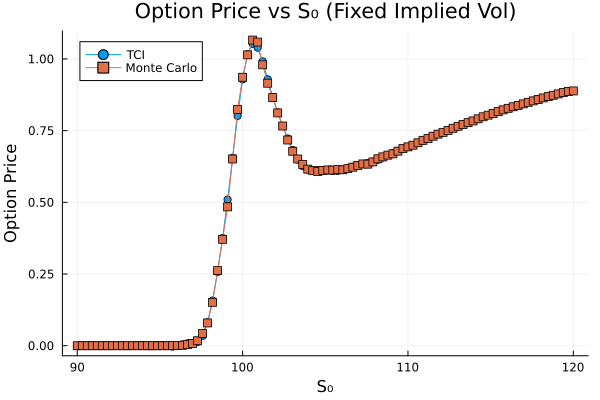

In [14]:
# using Plots
# プロット: Option Price vs S₀
plot(S0_values, D * price_vector_tci,
    label = "TCI",
    lw = 1,
    marker = :circle,
    title = "Option Price vs S₀ (Fixed Implied Vol)",
    xlabel = "S₀",
    ylabel = "Option Price")

plot!(S0_values, D * price_vector_mc,
    label = "Monte Carlo",
    lw = 1,
    marker = :square)




In [15]:
price_vector_mc

100-element Vector{Float64}:
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  ⋮
 14.087526527123767
 14.347042630539233
 14.608079502223246
 14.870663413918209
 15.134577701462009
 15.399998726991386
 15.666708626035408
 15.934910572580645
 16.204164912599882

In [16]:
# 等間隔グリッドの作成（一次元：S₀ のみ変化、インプライド・ボラティリティは固定）
num_nodes = 100
S0_values = collect(range(90.0, stop=120.0, length=num_nodes))
implied_vol_values = collect(range(0.15, stop=0.25, length=num_nodes))
fixed_vol = implied_vol_values[div(num_nodes,2)+1]  # 中央の値を固定

# TCIによる評価結果（一次元ベクトル）の作成
price_vector_tci_ = zeros(length(S0_values))
for (i_idx, s0_val) in enumerate(S0_values)
    # 固定されたインプライド・ボラティリティで Chebyshev基底を評価
    weights = [chebyshev_basis_derivative(90.0, 120.0, s0_val, n),
               chebyshev_basis(0.15, 0.25, fixed_vol, n)]
    c = 1
    left_cache  = compute_left_cache(C_coeff_tensor, weights, c)
    right_cache = compute_right_cache(C_coeff_tensor, weights, c)
    result_original = update_center(C_coeff_tensor, left_cache, right_cache, weights[c], c)
    price_vector_tci_[i_idx] = result_original
end



In [17]:
price_vector_tci_

100-element Vector{Float64}:
 NaN
   0.003982649596637346
  -0.004913595664412899
   0.004127102409268032
  -0.003742461273486539
   0.002185212819573788
   0.0009427300072843689
  -0.0032700090839183965
   0.0016419289061418406
   0.0023753773604006053
   ⋮
   0.8545817944259405
   0.857648551022695
   0.8642499618546116
   0.8697322402635959
   0.8718750415753697
   0.8798555166967504
   0.8808732454026273
   0.8878031639744419
 NaN

In [18]:
D * price_vector_tci 

100-element Vector{Float64}:
 -0.0023458286125478682
 -0.0007267501489272994
  0.0006865203140188379
  0.00021997725676497235
 -0.0007592695863515489
  0.0006468421240589397
  0.00042755271675612005
 -0.0015351259779357023
  0.0008310247978189667
  0.0013392529236930719
  ⋮
  0.8542441355646804
  0.8583197648778983
  0.8640633156794072
  0.869028587587246
  0.8731195857837803
  0.8783052877715516
  0.8827604619850327
  0.8861980793749294
  0.8878219744051802

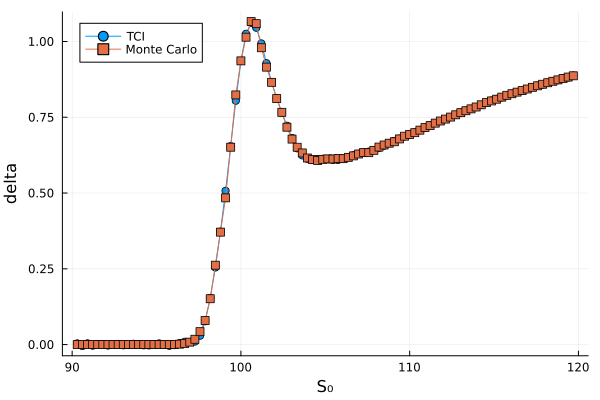

In [19]:
# using Plots
# プロット: Option Price vs S₀
plot(S0_values[2:end-1], price_vector_tci_[2:end-1],
    label = "TCI",
    lw = 1,
    marker = :circle,
    title = "",
    xlabel = "S₀",
    ylabel = "delta")

plot!(S0_values[2:end-1], (D * price_vector_mc)[2:end-1],
    label = "Monte Carlo",
    lw = 1,
    marker = :square)




In [20]:
savefig("S0_asian_delta.pdf")

"/Users/sakurairihito/Documents/Research/post-doc/Tensor_FixedSeedMC/notebook/cheby_TCI/single_assets/asian_barrier/cheby_tci/first_order_derivative/delta_/S0_asian_delta.pdf"